In [26]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
import pydotplus
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict
import itertools
from sklearn.ensemble import RandomForestClassifier

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Serif"],
})

## Decision Trees
Decision trees map a set of input features to their corresponding output targets through a series of decisions, each one representing a node (or branching) of the tree. The decision at each branch is determined from the training data by the decision tree learning algorithm. Different algorithms use different metrics to split the data effectively. Decision trees can be used for regression and classification, both of which will be explored here, in that order.

In [2]:
def get_features_targets(data):
    '''
    Split training data into features and targets.

    Returns
    -------
    features : array_like
        m x 4 feature array where m is the number of galaxies.

    targets : array_like
        1d array of length m containing the redshift of each galaxy.
        
    '''
    features = np.zeros((data.shape[0], 4))
    features[:, 0] = data['u'] - data['g']
    features[:, 1] = data['g'] - data['r']
    features[:, 2] = data['r'] - data['i']
    features[:, 3] = data['i'] - data['z']

    targets = data['redshift']
    return features, targets

data = np.load('sdss_galaxy_colors.npy')
features, targets = get_features_targets(data)

print(targets)

[0.539301   0.1645703  0.04190006 ... 0.0784592  1.567295   0.4749449 ]


In [3]:
# Initialise decision tree regression learning algorithm.
dtr = DecisionTreeRegressor()

# Train the model. 
dtr.fit(features, targets)

# Make predictions.
predictions = dtr.predict(features)

In [4]:
def median_diff(predicted, actual):
  '''
  Calculate the median absolute difference between predicted and actual values.

  Parameters
  ----------
  predicted : array_like
      Predicted values.
  actual : array_like
      Actual values.

  Returns
  -------
  float
      The median absolute difference between predicted and actual values.

  Raises
  ------
  ValueError
      If the lengths of `predicted` and `actual` are not equal.
      
  '''
  return np.median(np.abs(predicted[:]-actual[:]))

# Measure the accuracy of the predictions.
diff = median_diff(predictions, targets)

# Print the median difference.
print("Median difference: {:0.3f}".format(diff))

Median difference: 0.000


### Validation
A value of 0.000 for our median difference would suggest the model is _perfectly_ accurate, which is unrealistic. We have used the same data to train and test our model, so the model has been optimised to obtain the best results on the training data, and will not perform as well for unseen galaxies. This is why we should split our data into *training* and *testing* sets.

In [5]:
from sklearn.tree import export_text

# Initialize model.
dtr = DecisionTreeRegressor(max_depth=3) 

# Split the data into training and testing sets.
split_index = int(0.5 * len(features))
train_features = features[:split_index]
train_targets = targets[:split_index]

dtr.fit(train_features, train_targets)

# Export the decision tree graph.
dot_data = export_text(dtr, feature_names=['u - g', 'g - r', 'r - i', 'i - z'])

# Create the graph from the modified DOT data.
graph = pydotplus.graph_from_dot_data(
            export_graphviz(
                dtr, 
                out_file=None, 
                feature_names=['u - g', 'g - r', 'r - i', 'i - z'], 
                fontname='serif')
            )

# Set the font for the graph nodes and edges.
for node in graph.get_nodes():
    node.set_fontname('serif')

for edge in graph.get_edges():
    edge.set_fontname('serif')

graph.set_dpi(500)

# Write the graph to a PNG file
graph.write_png('decision_tree.png')

True

In [6]:
from sklearn.model_selection import train_test_split

def validate_model(model, features, targets):
    '''
    Validate a machine learning model by measuring the median absolute difference between predicted and actual values.

    Parameters
    ----------
    model : object
        The machine learning model to validate.
    features : array_like
        The input features for training and testing the model.
    targets : array_like
        The target values for training and testing the model.

    Returns
    -------
    float
        The median absolute difference between predicted and actual values.

    Raises
    ------
    ValueError
        If the lengths of `features` and `targets` are not equal.
        
    '''
    # Split data into training and testing features and predictions.
    train_features, test_features, train_targets, test_targets =\
    train_test_split(features, targets, test_size=0.2, random_state=10)

    # Train the model.
    model.fit(train_features, train_targets)

    # Make predictions.
    predictions = model.predict(test_features)

    # Measure the accuracy of the predictions.
    return median_diff(test_targets, predictions)

data = np.load('sdss_galaxy_colors.npy')
features, targets = get_features_targets(data)

# Initialize model.
dtr = DecisionTreeRegressor()

# Validate the model and print median difference.
diff = validate_model(dtr, features, targets)
print('Median difference: {:f}'.format(diff))

Median difference: 0.021565


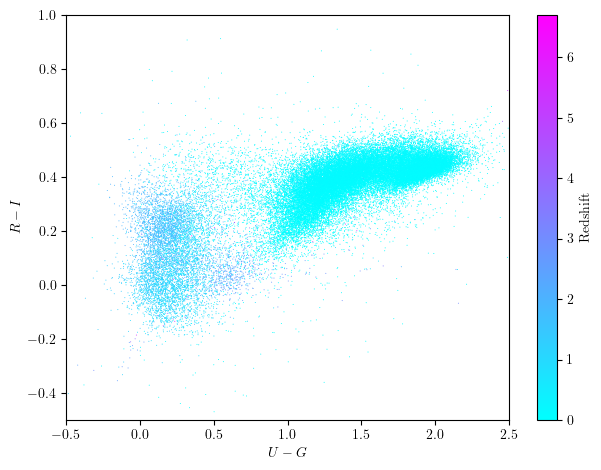

In [7]:
data = np.load('sdss_galaxy_colors.npy')

# Get a colour map.
cmap = plt.get_cmap('cool')

# Define colour indexes u-g and r-i.
u_g = data['u'] - data['g']
r_i = data['r'] - data['i']

# Make a redshift array.
redshift = data['redshift']

# Plot the colours.
colours = plt.scatter(u_g, r_i, s=0.5, lw=0, c=redshift, cmap=cmap)
cb = plt.colorbar(colours)
cb.set_label('Redshift')

plt.xlabel('$U - G$')
plt.ylabel('$R - I$')
# plt.title('Redshift $U-G$ vs $R-I$')

plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1)

plt.tight_layout()
plt.savefig('colour_redshift.png', dpi=500)

Decision trees have a tendency to overfit data if left unchecked, meaning they try to account for outliers at the cost of the predictive accuracy of the general trend. To see how the tree is overfitting, we can examine its accuracy at different depths. Here, we look at how it performs on test data compared to the training data. We would naturally expect that the deeper the tree, the better the fit, but overfitting can quickly become an issue with test data at higher depths.

In [8]:
def accuracy_by_treedepth(features, targets, depths):
    '''
    Calculate median absolute differences for decision tree regression models with varying depths.

    Parameters
    ----------
    features : array_like
        Input features for training and testing the models.
    targets : array_like
        Target values for training and testing the models.
    depths : array_like
        List of depths to test for decision tree regression models.

    Returns
    -------
    tuple
        A tuple containing two lists:
        - train_accuracies: Median absolute differences for training set predictions at each depth.
        - test_accuracies: Median absolute differences for testing set predictions at each depth.
        
    '''
    train_accuracies = []
    test_accuracies = []

    # Split the data into testing and training sets.
    train_features, test_features, train_targets, test_targets =\
        train_test_split(features, targets, test_size=0.2, random_state=10)
    
    # Loop through different depths.
    for depth in depths:
        # Initialize model with the maximum depth.
        dtr = DecisionTreeRegressor(max_depth=depth)

        # Train the model using the training set.
        dtr.fit(train_features, train_targets)

        # Get the predictions for the training set and calculate their median difference.
        train_predictions = dtr.predict(train_features)
        train_accuracy = median_diff(train_predictions, train_targets)
        train_accuracies.append(train_accuracy)

        # Get the predictions for the testing set and calculate their median difference.
        test_predictions = dtr.predict(test_features)
        test_accuracy = median_diff(test_predictions, test_targets)
        test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies

Depth with lowest median difference : 19


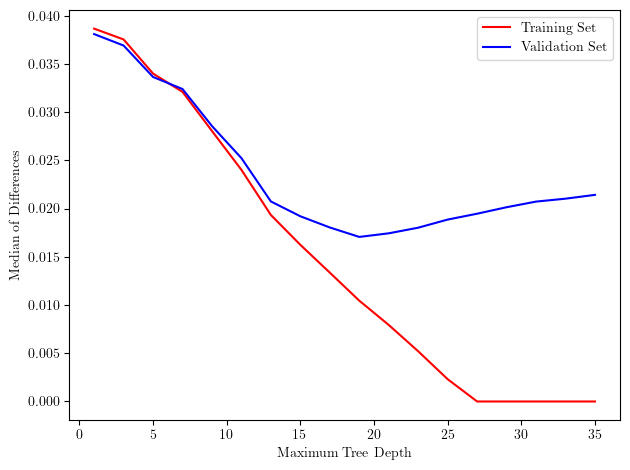

In [9]:
data = np.load('sdss_galaxy_colors.npy')
features, targets = get_features_targets(data)

# Generate several depths to test.
tree_depths = [i for i in range(1, 36, 2)]

# Call the function.
train_med_diffs, test_med_diffs = accuracy_by_treedepth(features, targets, tree_depths)
print("Depth with lowest median difference : {}".format(tree_depths[test_med_diffs.index(min(test_med_diffs))]))

# Plot the results.
train_plot = plt.plot(tree_depths, train_med_diffs, label='Training Set', color='r')
test_plot = plt.plot(tree_depths, test_med_diffs, label='Validation Set', color='b')
plt.xlabel("Maximum Tree Depth")
plt.ylabel("Median of Differences")
plt.legend()

plt.tight_layout()
plt.savefig('depth_v_median', dpi=800)

### Improved Validation
So far, we have validated our model using hold-out validation, which is the most basic kind of validation. All we have done is split the data into two sets: a training and a test set. This method is limited by its dependence on how exactly the training and test sets are split, so the median difference that we get from one randomly sampled training set will be different to that of a different randomly sampled set of the same size. 

A more robust method is $k$-fold cross validation. Here, we split the data into $k$ folds, train the model on $k-1$ folds, and validate it on the remaining fold. The median absolute difference between predicted and actual values is calculated for each fold. We take the average of the $k$ accuracy measurements to be the model's overall accuracy.

In [10]:
from sklearn.model_selection import KFold

def cross_validate_model(model, features, targets, k):
    '''
    Perform k-fold cross-validation to validate a machine learning model.

    Parameters
    ----------
    model : object
        The machine learning model to cross-validate.
    features : array_like
        Input features for training and testing the model.
    targets : array_like
        Target values for training and testing the model.
    k : int
        Number of folds for cross-validation.

    Returns
    -------
    list
        List of median absolute differences between predicted and actual values for each fold.
        
    '''
    kf = KFold(n_splits=k, shuffle=True)
    median_diffs = []

    for train_indices, test_indices in kf.split(features):
        train_features, test_features = features[train_indices], features[test_indices]
        train_targets, test_targets = targets[train_indices], targets[test_indices]
        
        # Fit the model for the current set.
        model.fit(train_features, train_targets)

        # Predict using the model.
        predictions = model.predict(test_features)

        # Calculate the median difference from predicted values and append to list.
        median_diffs.append(median_diff(predictions, test_targets))

    return median_diffs

In [11]:
data = np.load('./sdss_galaxy_colors.npy')
features, targets = get_features_targets(data)

# Initialize model with a maximum depth of 19.
dtr = DecisionTreeRegressor(max_depth=19)

diffs = cross_validate_model(dtr, features, targets, 10)

# Print values.
print('Differences: {}'.format(', '.join(['{:.3f}'.format(val) for val in diffs])))
print('Mean difference: {:.3f}'.format(np.mean(diffs)))

Differences: 0.017, 0.017, 0.017, 0.017, 0.017, 0.018, 0.018, 0.017, 0.017, 0.018
Mean difference: 0.017


In [12]:
def cross_validate_predictions(model, features, targets, k):
    '''
    Perform k-fold cross-validation to generate predictions using a machine learning model.

    Parameters
    ----------
    model : object
        The machine learning model to cross-validate.
    features : array_like
        Input features for training and testing the model.
    targets : array_like
        Target values for training and testing the model.
    k : int
        Number of folds for cross-validation.

    Returns
    -------
    array_like
        Array of predicted values generated by the model during cross-validation.
        
    '''
    kf = KFold(n_splits=k, shuffle=True)

    # Declare an array for predicted redshifts from each iteration.
    all_predictions = np.zeros_like(targets)

    for train_indices, test_indices in kf.split(features):
        # Split the data into training and testing.
        train_features, test_features = features[train_indices], features[test_indices]
        train_targets, test_targets = targets[train_indices], targets[test_indices]

        # Fit the model for the current set.
        model.fit(train_features, train_targets)

        # Predict using the model.
        predictions = model.predict(test_features)

        # Put the predicted values into the array defined above.
        all_predictions[test_indices] = predictions

    return all_predictions

Median difference: 0.017


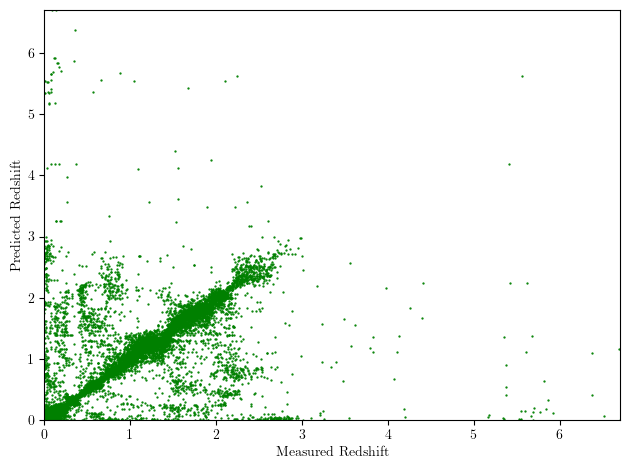

In [13]:
data = np.load('./sdss_galaxy_colors.npy')
features, targets = get_features_targets(data)

# Initialize the model.
dtr = DecisionTreeRegressor(max_depth=19)

# Make predictions.
predictions = cross_validate_predictions(dtr, features, targets, 10)

# Calculate and print the median difference as a sanity check.
diffs = median_diff(predictions, targets)
print('Median difference: {:.3f}'.format(diffs))

# Plot the results to evaluate the model.
plt.scatter(targets, predictions, s=0.4, color='g')
plt.xlim((0, targets.max()))
plt.ylim((0, predictions.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Predicted Redshift')

plt.tight_layout()
plt.savefig('measured_v_predicted_z', dpi=800)

### QSOs vs Galaxies
Our galaxy data consists of two different populations: regular galaxies and quasi-stellar objects (QSOs). While most of the regular galaxies in the dataset have $z \le 0.4$, QSOs can have redshifts all the way up to $z\approx 6$. Due to the high-redshift QSO contribution, the flux magnitudes we measure at different wavelengths may not follow the profile we initially assumed when predicting redshifts. It is therefore worth examining whether there is a difference in accuracy of the decision trees between regular galaxies and QSOs.

In [14]:
def split_galaxies_qsos(data):
    '''
    Split data into galaxies and quasars (QSOs) based on spectral class.

    Parameters
    ----------
    data : array_like
        Input data containing information about objects.

    Returns
    -------
    tuple
        A tuple containing two arrays:
        - galaxies: Array of objects classified as galaxies.
        - qsos: Array of objects classified as quasars (QSOs).
        
    '''
    # Initialize empty lists to store galaxies and QSOs.
    galaxies = []
    qsos = []

    # Loop through the data and separate galaxies and QSOs.
    for row in data:
        # Check if the spectral class is 'GALAXY' (as a byte string)
        if row['spec_class'] == b'GALAXY':
            galaxies.append(row)
        else:
            qsos.append(row)

    # Convert lists to arrays.
    galaxies = np.array(galaxies)
    qsos = np.array(qsos)
    
    return galaxies, qsos

In [15]:
def cross_validate_median_diff(data):
    '''
    Perform cross-validation to estimate the mean median absolute difference of a decision tree regression model.

    Parameters
    ----------
    data : array_like
        Input data containing features and targets.

    Returns
    -------
    float
        Mean median absolute difference of the decision tree regression model estimated by cross-validation.
    
    '''
    features, targets = get_features_targets(data)
    dtr = DecisionTreeRegressor(max_depth=19)

    return np.mean(cross_validate_model(dtr, features, targets, 10))

data = np.load('./sdss_galaxy_colors.npy')

# Split the data set into galaxies and QSOs.
galaxies, qsos = split_galaxies_qsos(data)

# Cross validate the model and get the cross-validated median difference.
galaxy_med_diff = cross_validate_median_diff(galaxies)
qso_med_diff = cross_validate_median_diff(qsos)

# Print the results.
print("Median difference for Galaxies: {:.3f}".format(galaxy_med_diff))
print("Median difference for QSOs: {:.3f}".format(qso_med_diff))

Median difference for Galaxies: 0.016
Median difference for QSOs: 0.074


## Classification
In regression, the accuracy of the model is evaluated based on the size of the differences between the predicted and actual values, and the prediction can correspond to a continuum of possible values. In classification, however, a prediction can be either correct or incorrect, which makes it simpler to evaluate the model's accuracy.

As in the case of regression, we need to decide on a set of key features to represent the data. Most of the features we will use here are based on the observed flux magnitudes from the Sloan Digital Sky Survey filters: _colour index, adaptive moments, eccentricities_, and _concentrations_.  

The colour indices are the same colours (u-g, g-r, r-i, and i-z) that were used for regression. Spiral galaxies tend to have younger star populations and are therefore 'bluer', while elliptical galaxies tend to have older star populations and are therefore 'redder'.

The eccentricity approximates the shape of the galaxy by fitting an ellipse to its profile. Here we use the median eccentricity across the 5 filters. 

Adaptive moments describe the shape of a galaxy. They are used in image analysis to detect similar objects at different sizes and orientations. Here the fourth moment for each band is used.

Concentration measures what proportion of a galaxy's light is emitted at different radii. A simplified representatoin of this is the ratio of the radii containing 50% and 90% of the Petrosian flux,
$$ C = \frac{\text{petro}_{R50}}{\text{petro}_{R90}}. $$
The concentrations from the u, r, and z bands are used.

In [16]:
def splitdata_train_test(data, fraction_training):
    '''
    Split data into training and testing sets.

    Parameters
    ----------
    data : array_like
        Input data to be split into training and testing sets.
    fraction_training : float
        Fraction of data to be included in the training set.

    Returns
    -------
    tuple
        A tuple containing two arrays:
        - training_set: Array of samples for the training set.
        - testing_set: Array of samples for the testing set.
        
    '''
    # Shuffle the data randomly.
    np.random.shuffle(data)
    
    # Calculate the number of samples for the training set.
    num_training = int(len(data) * fraction_training)
    
    # Split the data into training and testing sets.
    training_set = data[:num_training]
    testing_set = data[num_training:]
    
    return training_set, testing_set

In [17]:
data = np.load('galaxy_catalogue.npy')

# Set the fraction of data which should be in the training set.
fraction_training = 0.7

# Split the data.
training, testing = splitdata_train_test(data, fraction_training)

# Print the key values.
print('Number data galaxies:', len(data))
print('Train fraction:', fraction_training)
print('Number of galaxies in training set:', len(training))
print('Number of galaxies in testing set:', len(testing))

Number data galaxies: 780
Train fraction: 0.7
Number of galaxies in training set: 546
Number of galaxies in testing set: 234


In [18]:
def generate_features_targets(data):
    '''
    Generate features and targets from input data.

    Parameters
    ----------
    data : array_like
        Input data containing information about objects.

    Returns
    -------
    tuple
        A tuple containing two arrays:
        - features: Array of features derived from the input data.
        - targets: Array of target values derived from the input data.
        
    '''
    targets = data['class']

    features = np.empty(shape=(len(data), 13))
    features[:, 0] = data['u-g']
    features[:, 1] = data['g-r']
    features[:, 2] = data['r-i']
    features[:, 3] = data['i-z']
    features[:, 4] = data['ecc']
    features[:, 5] = data['m4_u']
    features[:, 6] = data['m4_g']
    features[:, 7] = data['m4_r']
    features[:, 8] = data['m4_i']
    features[:, 9] = data['m4_z']

    # Concentration in u filter
    features[:, 10] = data['petroR50_u'] / data['petroR90_u']
    # Concentration in r filter
    features[:, 11] = data['petroR50_r'] / data['petroR90_r']
    # Concentration in z filter
    features[:, 12] = data['petroR50_z'] / data['petroR90_z']

    return features, targets

In [19]:
data = np.load('galaxy_catalogue.npy')

# Generate features and targets.
features, targets = generate_features_targets(data)

# Print the shape of each array to check the arrays are the correct dimensions. 
print("Features shape:", features.shape)
print("Targets shape:", targets.shape)

Features shape: (780, 13)
Targets shape: (780,)


In [20]:
def dtc_predict_actual(data):
    '''
    Predict class labels using a decision tree classifier and compare with actual labels.

    Parameters
    ----------
    data : array_like
        Input data containing information about objects.

    Returns
    -------
    tuple
        A tuple containing two arrays:
        - predictions: Array of predicted class labels.
        - test_targets: Array of actual class labels.

    '''
    # Split the data into training and testing sets using a training fraction of 0.7.
    train_data, test_data = train_test_split(data, train_size=0.7, random_state=42)

    # Generate the feature and targets for the training and test sets.
    train_features, train_targets = generate_features_targets(train_data)
    test_features, test_targets = generate_features_targets(test_data)

    # Instantiate a decision tree classifier.
    dtc = DecisionTreeClassifier()

    # Train the classifier.
    dtc.fit(train_features, train_targets)

    # Get predictions for the features.
    predictions = dtc.predict(test_features)

    return predictions, test_targets

In [21]:
data = np.load('galaxy_catalogue.npy')

predicted_class, actual_class = dtc_predict_actual(data)

# Print some of the initial results.
print("Some initial results...\n   predicted, actual")
for i in range(10):
    print("{}. {}, {}".format(i, predicted_class[i], actual_class[i]))

Some initial results...
   predicted, actual
0. spiral, spiral
1. spiral, spiral
2. merger, spiral
3. spiral, spiral
4. elliptical, elliptical
5. spiral, merger
6. merger, elliptical
7. spiral, spiral
8. merger, merger
9. spiral, spiral


### Confusion Matrices
In addition to the overall accuracy, it is useful to have information on where the model goes wrong. To investigate this, we use a confusion matrix. The x-axis represents the predicted classes, while the y-axis represents the correct classes. The value in each cell is the number of examples with those predicted and actual classes. Correctly classified objects lie along the diagonal of the matrix.

In [22]:
def calculate_accuracy(predicted, actual):
    '''
    Calculate the accuracy of predicted class labels compared to actual class labels.

    Parameters
    ----------
    predicted : array_like
        Array of predicted class labels.
    actual : array_like
        Array of actual class labels.

    Returns
    -------
    float
        Accuracy of predicted class labels compared to actual class labels.

    '''
    accuracy = accuracy_score(actual, predicted)
    return accuracy

data = np.load('galaxy_catalogue.npy')

# Split the data.
features, targets = generate_features_targets(data)

# Train the model to get predicted and actual classes.
dtc = DecisionTreeClassifier()
predicted = cross_val_predict(dtc, features, targets, cv=10)

# Calculate the model score.
model_score = calculate_accuracy(predicted, targets)
print("Accuracy score:", model_score)

# Calculate the confusion matrix.
class_labels = list(set(targets))
model_cm = confusion_matrix(y_true=targets, y_pred=predicted, labels=class_labels)


Our accuracy score: 0.7858974358974359


Confusion matrix, without normalization


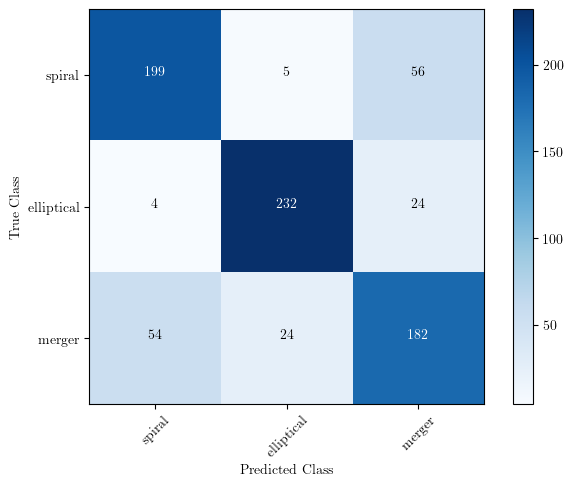

In [23]:
def plot_confusion_matrix(cm, classes, normalize, cmap=plt.cm.Blues):
    '''
    Plot the confusion matrix.

    Parameters
    ----------
    cm : array_like
        Confusion matrix to be plotted.
    classes : list
        List of class labels.
    normalize : bool, optional
        Whether to normalize the confusion matrix. Default is False.
    cmap : matplotlib.colors.Colormap, optional
        Colormap to be used for the plot. Default is plt.cm.Blues.

    Returns
    -------
    None

    '''

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{}".format(cm[i, j]),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    
# Plot the confusion matrix.
plt.figure()
plt.tight_layout()
plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)
plt.savefig('confusion_matrix_dtc', dpi=800)

## Random Forest Classifiers
So far, our model has consisted of a single decision tree. But we can improve the classification accuracy by using an ensemble of decision trees, independently trained using different subsets of the training data or different combinations of features in those subsets -- this is known as a random forest. Every tree in this forest gives its own prediction, and the most common classification is the overall forest prediction. Random forests help mitigate the impact of overfitting.

Training data is spread across decision trees. The subsets are created by taking random samples with replacement, so a given data point may be used in several subsets. This differs from the subsets used in cross validation, where each data point belongs to a single subset.

In [24]:
def rf_predict_actual(data, n_estimators):
    '''
    Predict class labels using a random forest classifier and compare with actual labels.

    Parameters
    ----------
    data : array_like
        Input data containing information about objects.
    n_estimators : int
        Number of trees in the random forest classifier.

    Returns
    -------
    tuple
        A tuple containing two arrays:
        - predictions: Array of predicted class labels.
        - targets: Array of actual class labels.

    '''
    # Generate the features and targets.
    features, targets = generate_features_targets(data)
    
    # Instantiate a random forest classifier.
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators)
    
    # Get predictions using 10-fold cross validation.
    predictions = cross_val_predict(rf_classifier, features, targets, cv=10)
    
    return predictions, targets

Accuracy score: 0.867948717948718
Confusion matrix, without normalization


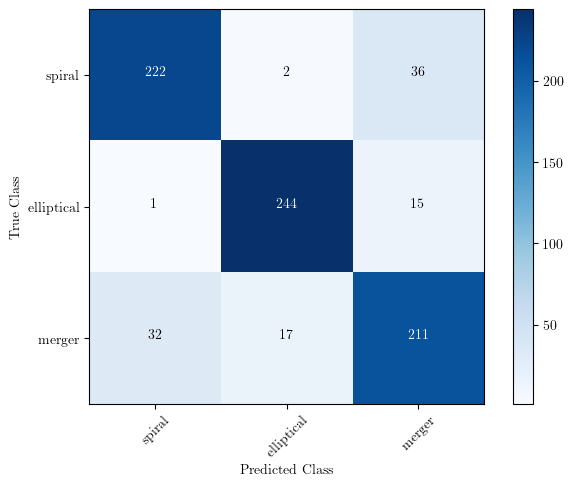

In [25]:
data = np.load('galaxy_catalogue.npy')

# Get the predicted and actual classes.
number_estimators = 50  # Number of trees
predicted, actual = rf_predict_actual(data, number_estimators)

# Calculate the model score.
accuracy = calculate_accuracy(predicted, actual)
print("Accuracy score:", accuracy)

# Calculate the confusion matrix.
class_labels = list(set(actual))
model_cm = confusion_matrix(y_true=actual, y_pred=predicted, labels=class_labels)

# Plot the confusion matrix.
plt.figure()
plt.tight_layout()
plot_confusion_matrix(model_cm, classes=class_labels, normalize=False)
plt.savefig('confusion_matrix_rf', dpi=800)